In [1]:
import os
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tidalUtl.InterfaceSQL as isq
import tidalUtl.PrpUtl as prp
import tidalUtl.EdaUtl as eda
import tidalUtl.VslUtl as vsl
import tidalUtl.ImgUtl as img

# loading some basic packages for testing
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import fetch_openml
#import xgboost as xgb

from tqdm.notebook import tqdm
from skimage import exposure, io
import cv2
from glob import glob
import pickle

import random
from random import randint

In [2]:
# config
INPUT = "/home/tidal/ML_Data/BMS_MolTrans/bms-molecular-translation"
OUTPUT = "/home/tidal/ML_Data/BMS_MolTrans/output"

# LABEL

In [3]:
df_train_labels = pd.read_csv(INPUT + "/train_labels.csv")
df_train_labels

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...


In [4]:
eda.chkDfIsNull(df_train_labels)

There is not NULL.


In [5]:
eda.chkUnique(df_train_labels, "image_id")

image_id is unique.


In [6]:
eda.chkUnique(df_train_labels, "InChI")

InChI is unique.


In [7]:
df_train_labels["InChI"][1000]

'InChI=1S/C19H20FNO4S/c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2/h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)/t17-,18+/m0/s1'

・レイヤーによって'/'で区切られる<font color="Red">（’/’の数を数えておくか...）</font><br>
・1S -> standardな書き方という意味らしい。'1'と'1S'しかないらしい<font color="Red">（比を調べておくこと）</font><br>
　また、1Sの場合は一部レイヤーが省略される（'/'が2つ減る）<br>
・元素の種類（CとかHとか）と数<br>
・メインレイヤー1：接頭文字:”c”として原子のつながりを記述する（炭素ではない）<br>
・メインレイヤー2：接頭文字:”h”として水素のつながりを記述する（炭素ではない）<br>
・サブレイヤー:電化、立体化学、同位体などを表すレイヤー(種類によって'/'でつなげていく)<br>
<font color="Red">データの並びが単純なものから複雑なものへと並んでる気がする（'/'が少ないか大きいか）</font><br>
<font color="Red">⇨区切りの多さでfold分けできそう</font><br>
例）<br>
InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3<br>
InChI=1S/C19H20FNO4S/c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2/h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)/t17-,18+/m0/s1<br>
[参考(wikipedia)](https://ja.wikipedia.org/wiki/InChI)

In [8]:
df_train_labels["InChI"][1000].split("/")

['InChI=1S',
 'C19H20FNO4S',
 'c1-12-3-6-15(7-4-12)26(24,25)21-10-9-17(19(22)23)18(21)16-8-5-14(20)11-13(16)2',
 'h3-8,11,17-18H,9-10H2,1-2H3,(H,22,23)',
 't17-,18+',
 'm0',
 's1']

In [9]:
INCHIs=df_train_labels["InChI"].values.tolist()

In [10]:
#レイヤー数の計算
INCHIsList=[]
for i, inchi in tqdm(enumerate(INCHIs)):
    #df_train_labels.loc[i, "layerNum"] = inchi.count("/")+1
    INCHIsList.append(inchi.count("/")+1)
    
layerNum_df = pd.DataFrame(INCHIsList, columns=["layerNum"])
df_train_labels = pd.concat([df_train_labels, layerNum_df], axis=1)

In [11]:
df_train_labels

,image_id,InChI,layerNum
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,4
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,7
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,4
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,4
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,4
...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,4
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,4
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,4
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,4


In [55]:
layerNum_df.value_counts().sort_index()

layerNum
3               307
4           1893702
5            133623
6               398
7            371839
8             24162
9               127
10               27
11                1
dtype: int64

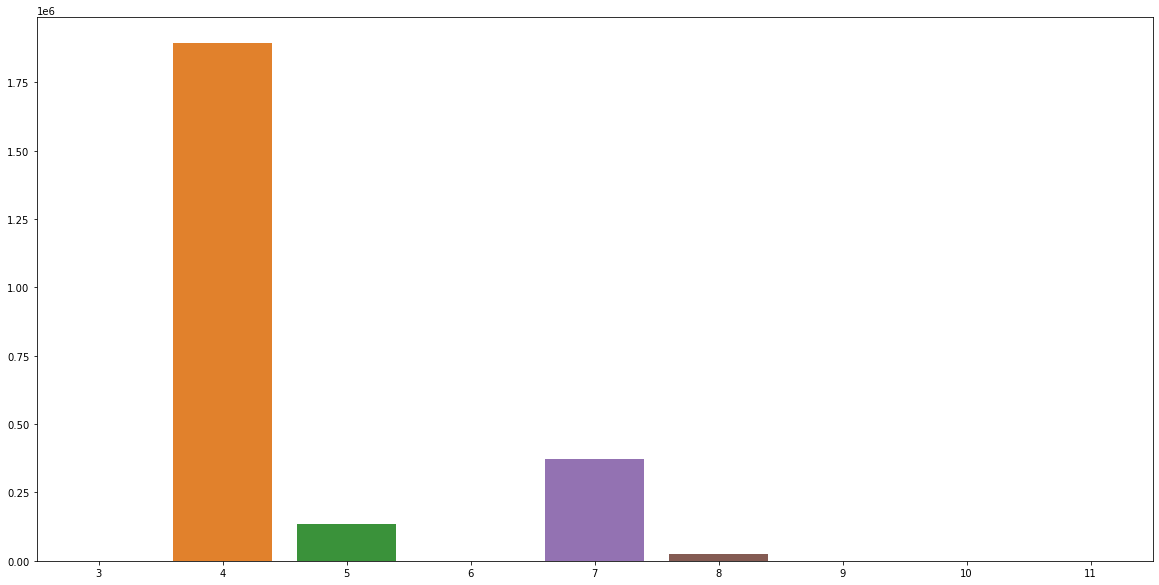

In [54]:
x = []
for i in range(len(layerNum_df.value_counts().index.tolist())):
    x.append(layerNum_df.value_counts().index.tolist()[i][0])
fig = plt.figure(figsize=(20,10))
sns.barplot(x = x, y = layerNum_df.value_counts().values)
plt.show()

・基本的にはレイヤーは4つ。バージョン/化学式/原子のつながり/水素原子の情報のみ。<br>
　バージョンはだいたい固定のはずなので予測するのは3つの情報<br>
・全体の5分の1が上記情報に合わせて立体情報などが入っていると思われる。(5個と7個)<br>
★**foldではこの個数が均等になるように分けること**

In [60]:
#バージョン(1S or 1)の可視化
INCHIs=df_train_labels["InChI"].values.tolist()
num_1 = 0
num_1s = 0
for i in range(len(INCHIs)):
    ver = INCHIs[i][6:8]
    if ver == "1S":
        num_1s += 1
    elif ver == "1/":
        num_1 += 1
    else:
        print(ver)

In [61]:
print(f"num_1:{num_1}")
print(f"num_1s:{num_1s}")

num_1:0
num_1s:2424186


バージョンは全て1S。<br>
★**submit時は決め打ちで最初を'InChI=1S/'にしておけば良い**

# IMAGE

In [62]:
def convert_image_id_2_path(image_id: str) -> str:
    return "../input/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )
